### **What’s a Decision Tree?**
A **Decision Tree** is like a flowchart that helps you make decisions step by step. Imagine you’re trying to decide which movie to watch on a Friday night and you’ve got a list of preferences.

- The **root node** represents the main question or decision you start with, such as, “Do I want a highly rated movie?”
- Each **internal node** represents a decision point based on a specific feature, like “Is the movie rated higher than 7?”
- The **branches** represent the possible answers to the question, like “Yes” or “No.”
- The **leaf nodes** are the outcomes of your decisions, such as “Watch a comedy” or “Watch an action movie.”

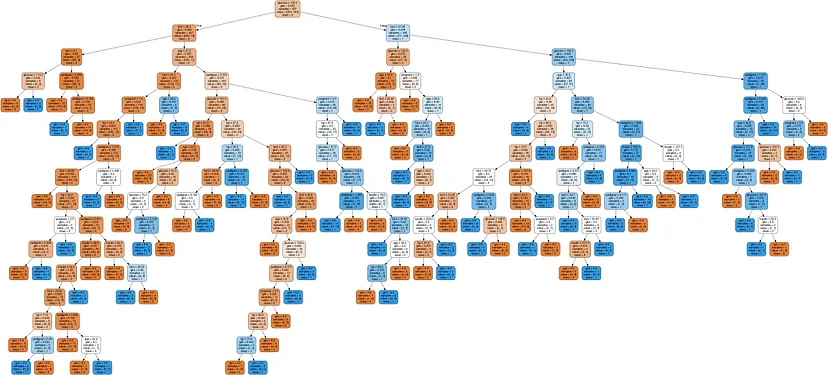

### **How Does it Work?**
A decision tree builds its structure by determining how well a feature splits the data into different categories. The goal is to find splits that maximize classification accuracy or prediction power.

**Key Metrics for Splitting**:
  - **Entropy**: Measures the level of uncertainty. The goal is to minimize entropy with each split. Let 𝑝𝑖 be the proportion of samples belonging to class.

  
      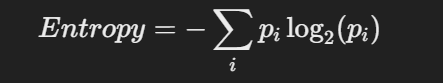

   - **Information Gain (IG)**: The reduction in entropy after a split.
   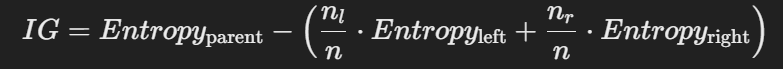
  - **Gini Impurity**: Measures how “impure” or mixed the groups are after a split. Lower Gini impurity = better split.
  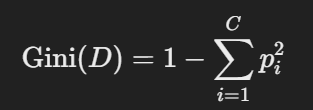
   - **Residual Sum of Squares (RSS)**: For regression problems, minimizes the error between predictions and actual values.


In [3]:
from collections import Counter
import numpy as np

def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

class Node:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

# Start at the root with all data, for each split, compute entropy and information gain for all features and thresholds.
# Choose the split that maximizes information gain.
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)
        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [4]:
# testing
if __name__ == "__main__":
    # Imports
    from sklearn import datasets
    from sklearn.model_selection import train_test_split

    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

    data = datasets.load_breast_cancer()
    X, y = data.data, data.target

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1234
    )

    clf = DecisionTree(max_depth=10)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy(y_test, y_pred)

    print("Accuracy:", acc)

Accuracy: 0.9385964912280702
